# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [3]:
data_dir = 'dataset2'
BATCH_SIZE = 64
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.7,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 2383 files belonging to 2 classes.
Using 715 files for training.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.7,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 2383 files belonging to 2 classes.
Using 1668 files for validation.


Show the first nine images and labels from the training set:

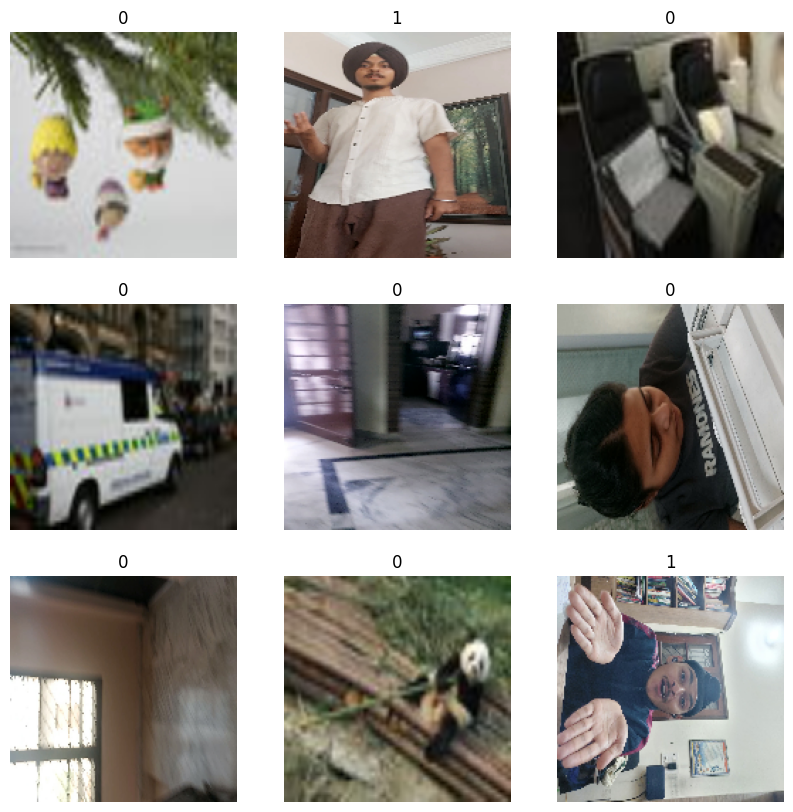

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 22
Number of test batches: 5


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

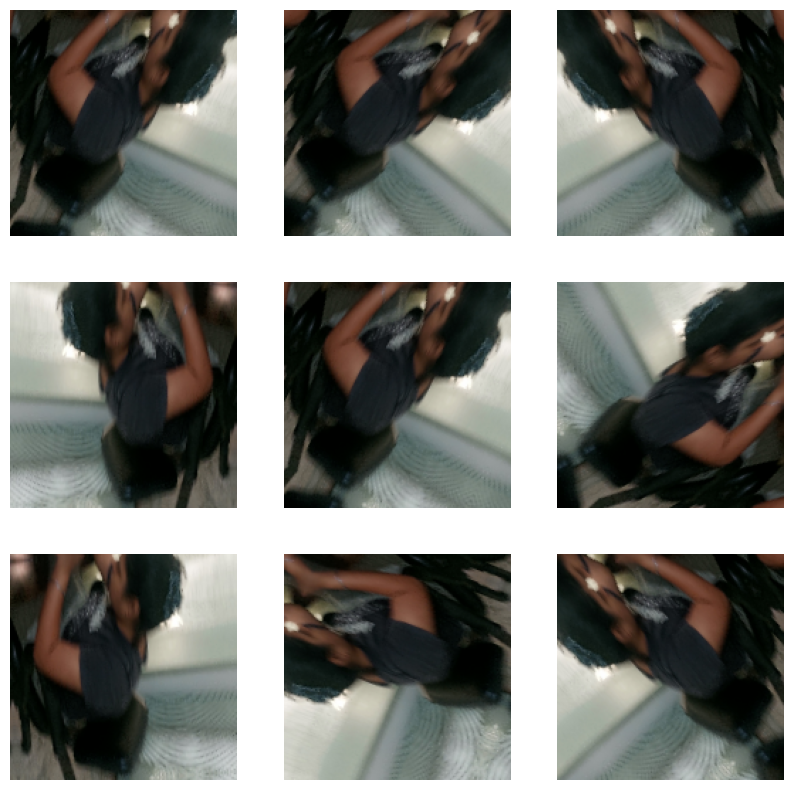

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(2, activation='relu')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 2)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1280 , activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [22]:
len(model.trainable_variables)

4

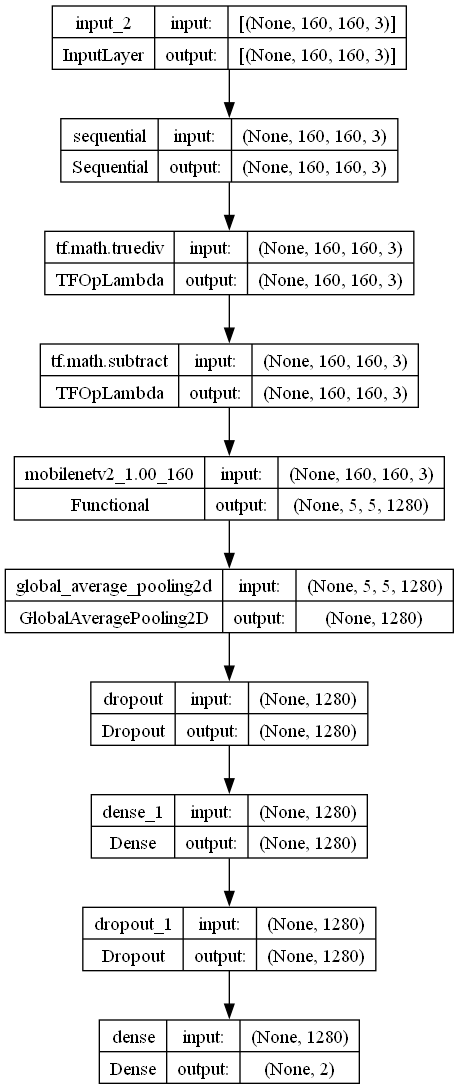

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

Compile the model before training it. Since there are two classes and a sigmoid oputput, use the `BinaryAccuracy`.

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [24]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])


### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.


In [25]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

22/22 [==============================] - 9s 191ms/step - loss: 0.7056 - accuracy: 0.5171


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.52


In [34]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
12/12 [==============================] - 12s 856ms/step - loss: 0.1237 - accuracy: 0.9524 - val_loss: 0.1575 - val_accuracy: 0.9377
Epoch 2/50
12/12 [==============================] - 13s 929ms/step - loss: 0.1132 - accuracy: 0.9497 - val_loss: 0.1522 - val_accuracy: 0.9407
Epoch 3/50
12/12 [==============================] - 14s 970ms/step - loss: 0.1135 - accuracy: 0.9580 - val_loss: 0.1698 - val_accuracy: 0.9362
Epoch 4/50
12/12 [==============================] - 14s 947ms/step - loss: 0.0992 - accuracy: 0.9636 - val_loss: 0.1817 - val_accuracy: 0.9332
Epoch 5/50
12/12 [==============================] - 13s 903ms/step - loss: 0.1026 - accuracy: 0.9594 - val_loss: 0.1478 - val_accuracy: 0.9436
Epoch 6/50
12/12 [==============================] - 13s 911ms/step - loss: 0.0907 - accuracy: 0.9664 - val_loss: 0.1781 - val_accuracy: 0.9303
Epoch 7/50
12/12 [==============================] - 14s 1s/step - loss: 0.0923 - accuracy: 0.9566 - val_loss: 0.1964 - val_accuracy: 0.9206
Ep

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

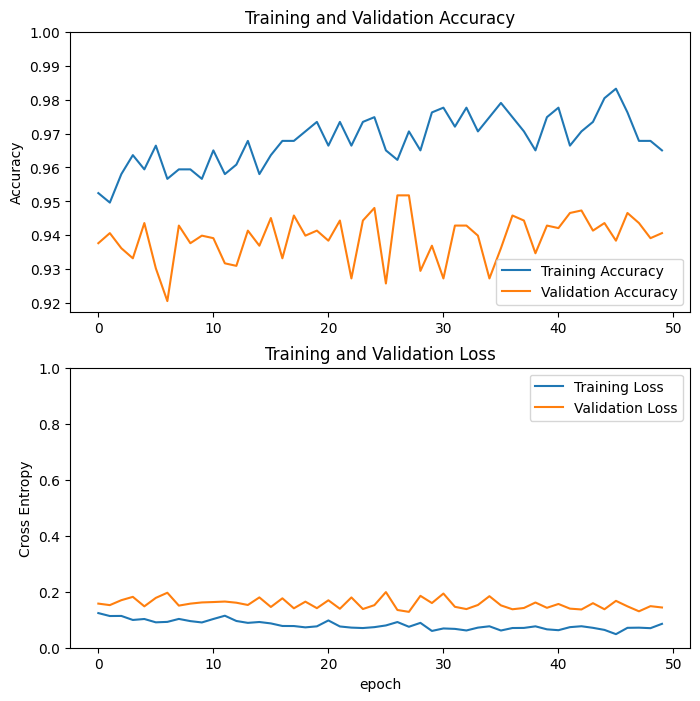

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

22/22 [==============================] - 7s 172ms/step - loss: 0.1329 - accuracy: 0.9473
Test accuracy : 0.9473294019699097


And now you are all set to use this model to predict if your pet is a cat or dog.

1/1 [==============================] - 0s 13ms/step


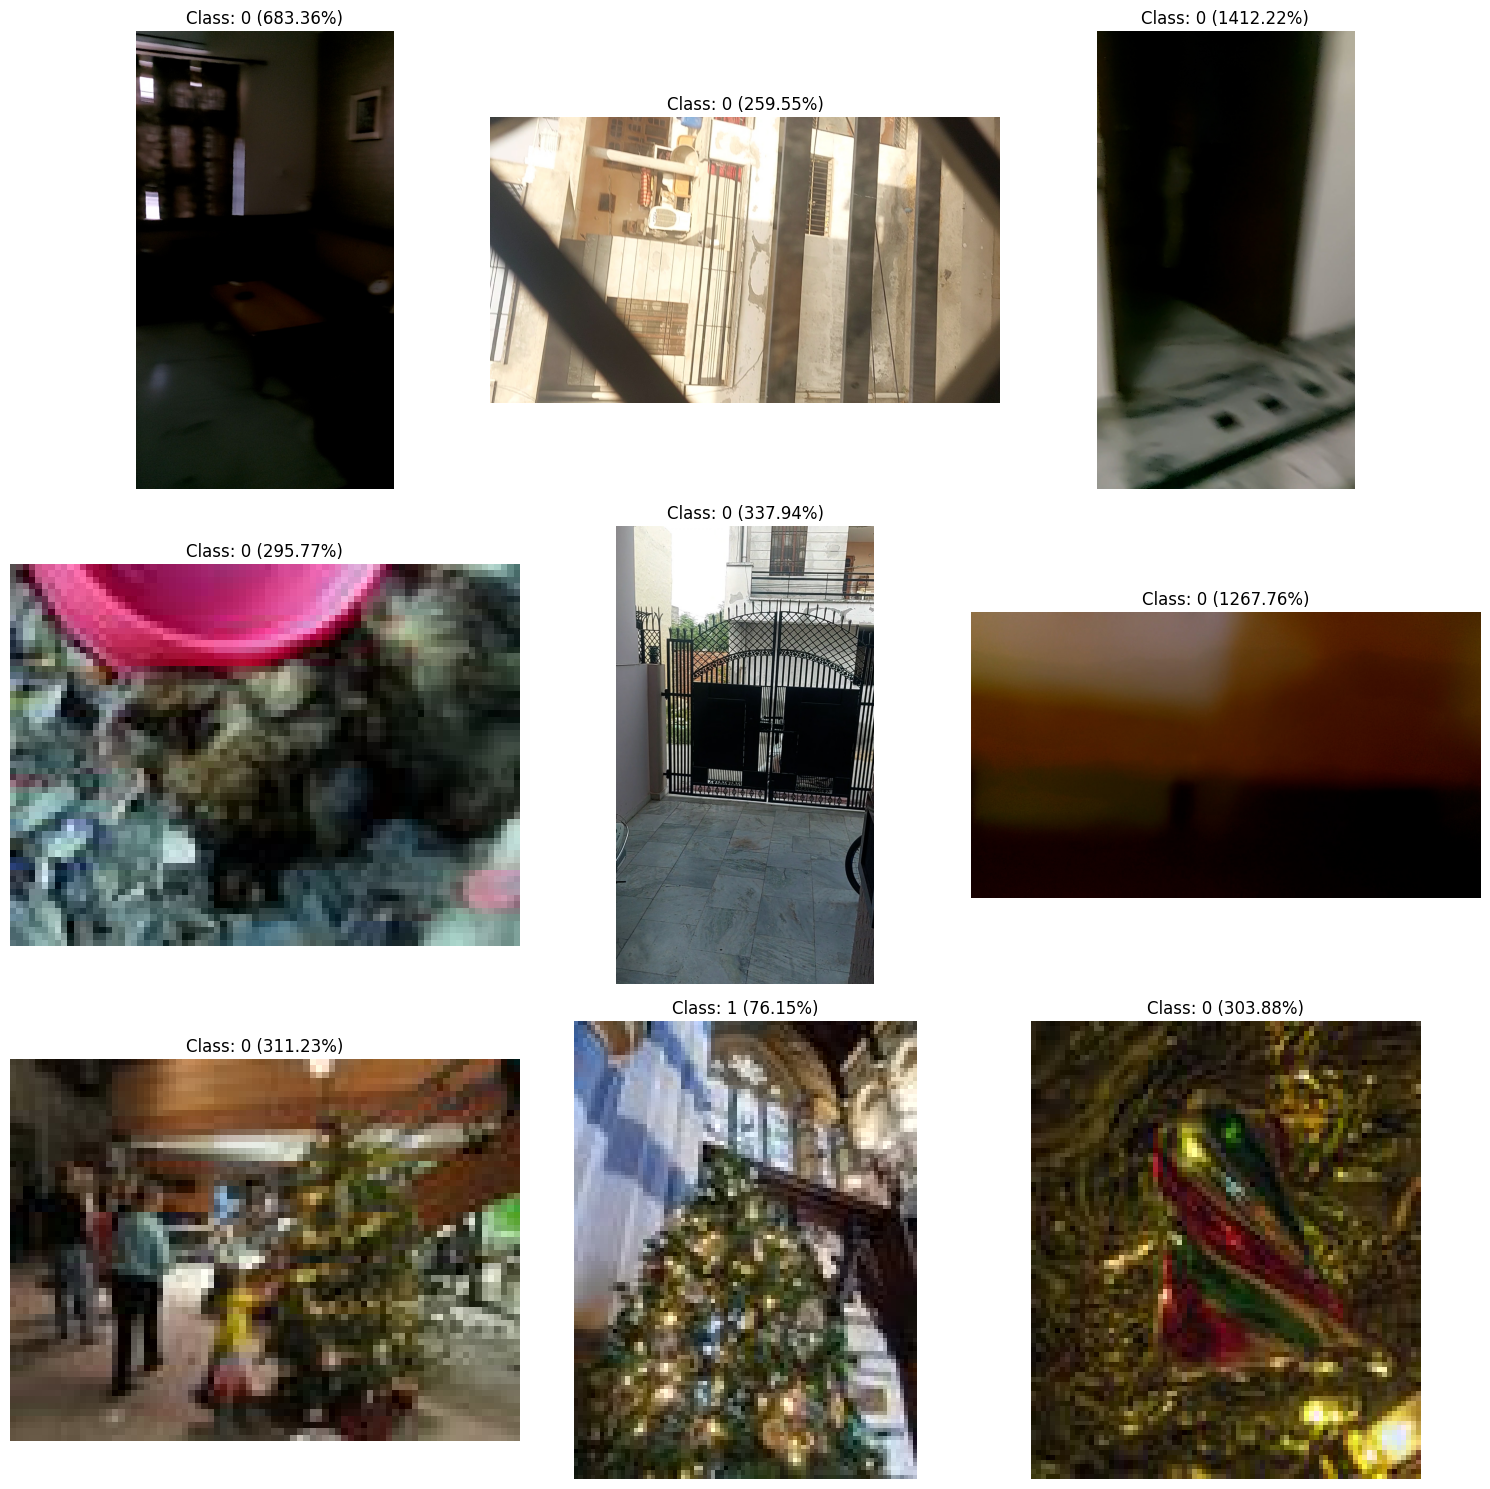

In [93]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(350, 350))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

# Function to plot images with predictions
def plot_images_with_predictions(images, predictions, class_names):
    plt.figure(figsize=(15, 15))
    for i, (img_path, prediction) in enumerate(zip(images, predictions)):
        score = tf.nn.relu(prediction)
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.keras.utils.load_img(img_path))
        plt.title("Class: {} ({:.2f}%)".format(class_names[np.argmax(score)], 100 * np.max(score)))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Load the model
#model = tf.keras.models.load_model('path_to_your_model')

# Path to the folder containing the images
folder_path = "dataset2/0"

# Get the list of image file names in the folder
image_files = os.listdir(folder_path)

# Randomly choose 9 image file names
random_images = random.sample(image_files, 9)

# Full paths to the images
image_paths = [os.path.join(folder_path, img_file) for img_file in random_images]

# Preprocess images and make predictions
images = []
predictions = []

for img_path in image_paths:
    img_array = load_and_preprocess_image(img_path)
    images.append(img_path)
    prediction = model.predict(img_array)
    predictions.append(prediction[0])

# Plot the images with their predictions
plot_images_with_predictions(images, predictions, class_names)



1/1 [==============================] - 0s 13ms/step


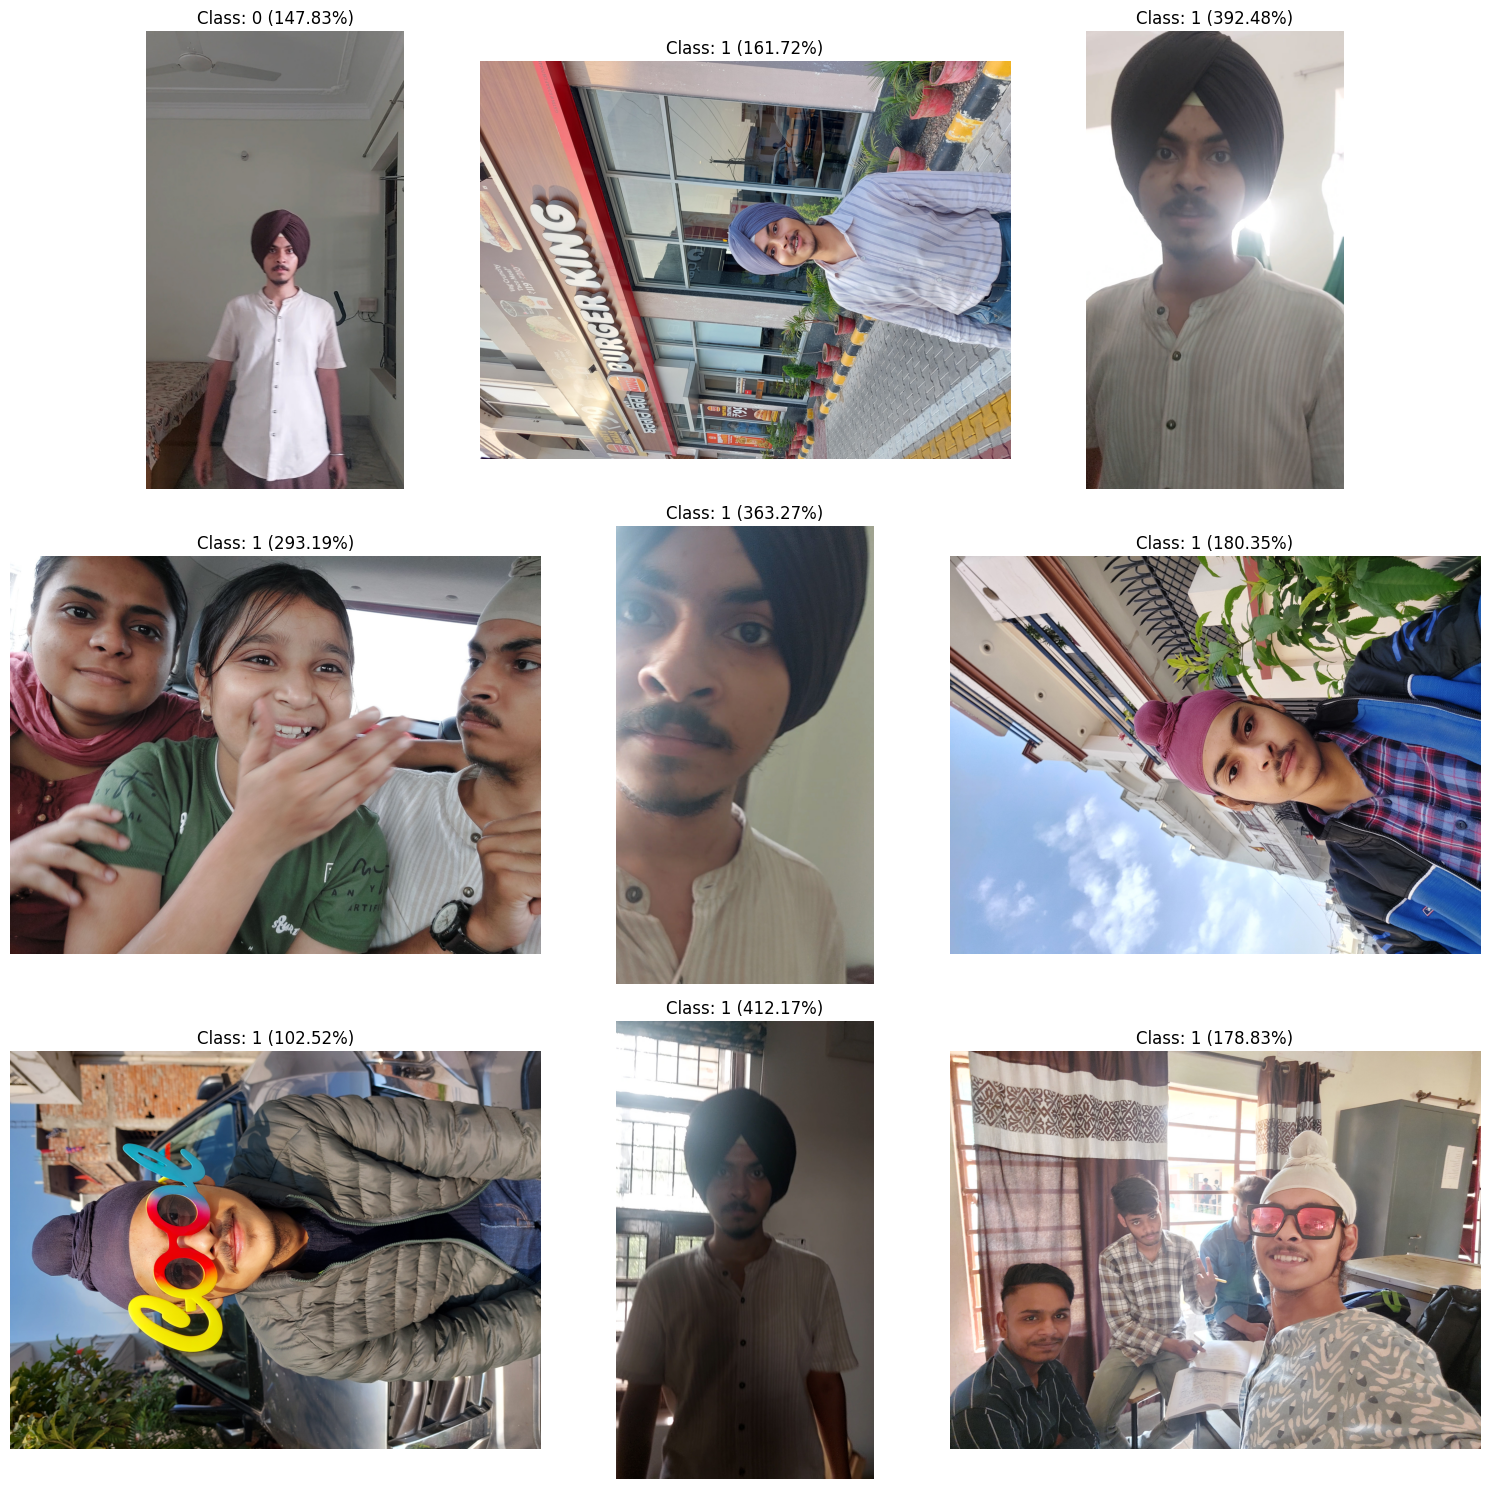

In [84]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(350, 350))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

# Function to plot images with predictions
def plot_images_with_predictions(images, predictions, class_names):
    plt.figure(figsize=(15, 15))
    for i, (img_path, prediction) in enumerate(zip(images, predictions)):
        score = tf.nn.relu(prediction)
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.keras.utils.load_img(img_path))
        plt.title("Class: {} ({:.2f}%)".format(class_names[np.argmax(score)], 100 * np.max(score)))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Load the model
#model = tf.keras.models.load_model('path_to_your_model')

# Path to the folder containing the images
folder_path = "dataset2/1"

# Get the list of image file names in the folder
image_files = os.listdir(folder_path)

# Randomly choose 9 image file names
random_images = random.sample(image_files, 9)

# Full paths to the images
image_paths = [os.path.join(folder_path, img_file) for img_file in random_images]

# Preprocess images and make predictions
images = []
predictions = []

for img_path in image_paths:
    img_array = load_and_preprocess_image(img_path)
    images.append(img_path)
    prediction = model.predict(img_array)
    predictions.append(prediction[0])

# Plot the images with their predictions
plot_images_with_predictions(images, predictions, class_names)



## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


In [694]:
model.save('best.keras')

In [ ]:
class_names

['No', 'yes']

In [33]:
import cv2
import time
# Initialize the camera
cap = cv2.VideoCapture(1) # 0 is the index of the built-in camera, change if you have multiple cameras

# Check if the camera opened successfully
if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

# Capture frames from the camera
while True:
    ret, frame = cap.read() # read a frame from the camera
    cv2.imwrite('captured_image.jpg', frame)

    time.sleep(5)

    img = tf.keras.utils.load_img(
    'captured_image.jpg', target_size=(160, 160)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    #print(predictions)
    score = tf.nn.relu(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    message = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
    #print(predictions)
    print(message)
    if not ret:
        print("Error: Can't receive frame (stream end?). Exiting ...")
        break

    # Display the resulting frame
    #cv2.imshow(message, frame)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 13ms/step
This image most likely belongs to 1 with a 363.21 percent confidence.
1/1 [==============================] - 0s 24ms/step
This image most likely belongs to 1 with a 304.65 percent confidence.
1/1 [==============================] - 0s 13ms/step
This image most likely belongs to 1 with a 423.41 percent confidence.
1/1 [==============================] - 0s 13ms/step
This image most likely belongs to 1 with a 404.12 percent confidence.
1/1 [==============================] - 0s 13ms/step
This image most likely belongs to 1 with a 464.05 percent confidence.
1/1 [==============================] - 0s 13ms/step
This image most likely belongs to 1 with a 523.14 percent confidence.
1/1 [==============================] - 0s 14ms/step
This image most likely belongs to 1 with a 414.19 percent confidence.
1/1 [==============================] - 0s 14ms/step
This image most likely belongs to 1 with a 426.21 percent confidence.
1/1 [===================

KeyboardInterrupt: 

In [690]:
img = tf.keras.utils.load_img(
'captured_image.jpg', target_size=(160, 160)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.relu(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
message = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
print(message)

1/1 [==============================] - 0s 17ms/step
[[0.        4.8376346]]
This image most likely belongs to Yes with a 483.76 percent confidence.
